In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
from PIL import Image
from typing import *
from tinydb import TinyDB, Query

from pulp_frontnet.PyTorch.Frontnet.DataProcessor import DataProcessor
from pulp_frontnet.PyTorch.Frontnet.Dataset import Dataset
from pulp_frontnet.PyTorch.Frontnet.Frontnet import FrontnetModel
from pulp_frontnet.PyTorch.Frontnet import Utils
from pulp_frontnet.PyTorch.Frontnet.Utils import ModelManager
from pulp_frontnet.PyTorch.Frontnet.ModelTrainer import ModelTrainer

from patch_optimizers.utils import *
from patch_optimizers.sliding_window_optimizer import SlidingWindowOptimizer
from patch_optimizers.simulated_annealing_optimizer import SimulatedAnnealingOptimizer
from patch_optimizers.random_optimizer import RandomOptimizer
from patch_optimizers.genetic_optimizer import GeneticOptimizer
from patch_optimizers.optimizer_interface import Optimizer

In [2]:
testset_path = "pulp_frontnet/PyTorch/Data/Data/160x96StrangersTestset.pickle"
[x_test, y_test] = DataProcessor.ProcessTestData(testset_path)

trainset_path = "pulp_frontnet/PyTorch/Data/Data/160x96OthersTrainsetAug.pickle"
[x_train, y_train] = DataProcessor.ProcessTestData(trainset_path)


# Create the PyTorch data loaders
test_set = Dataset(x_test, y_test)
test_loader = data.DataLoader(dataset=test_set, batch_size=1, shuffle=False, num_workers=1)

# do not use training set as it's quality is too low (augmentations not applied on ground truth)

In [3]:
len(test_set)

4028

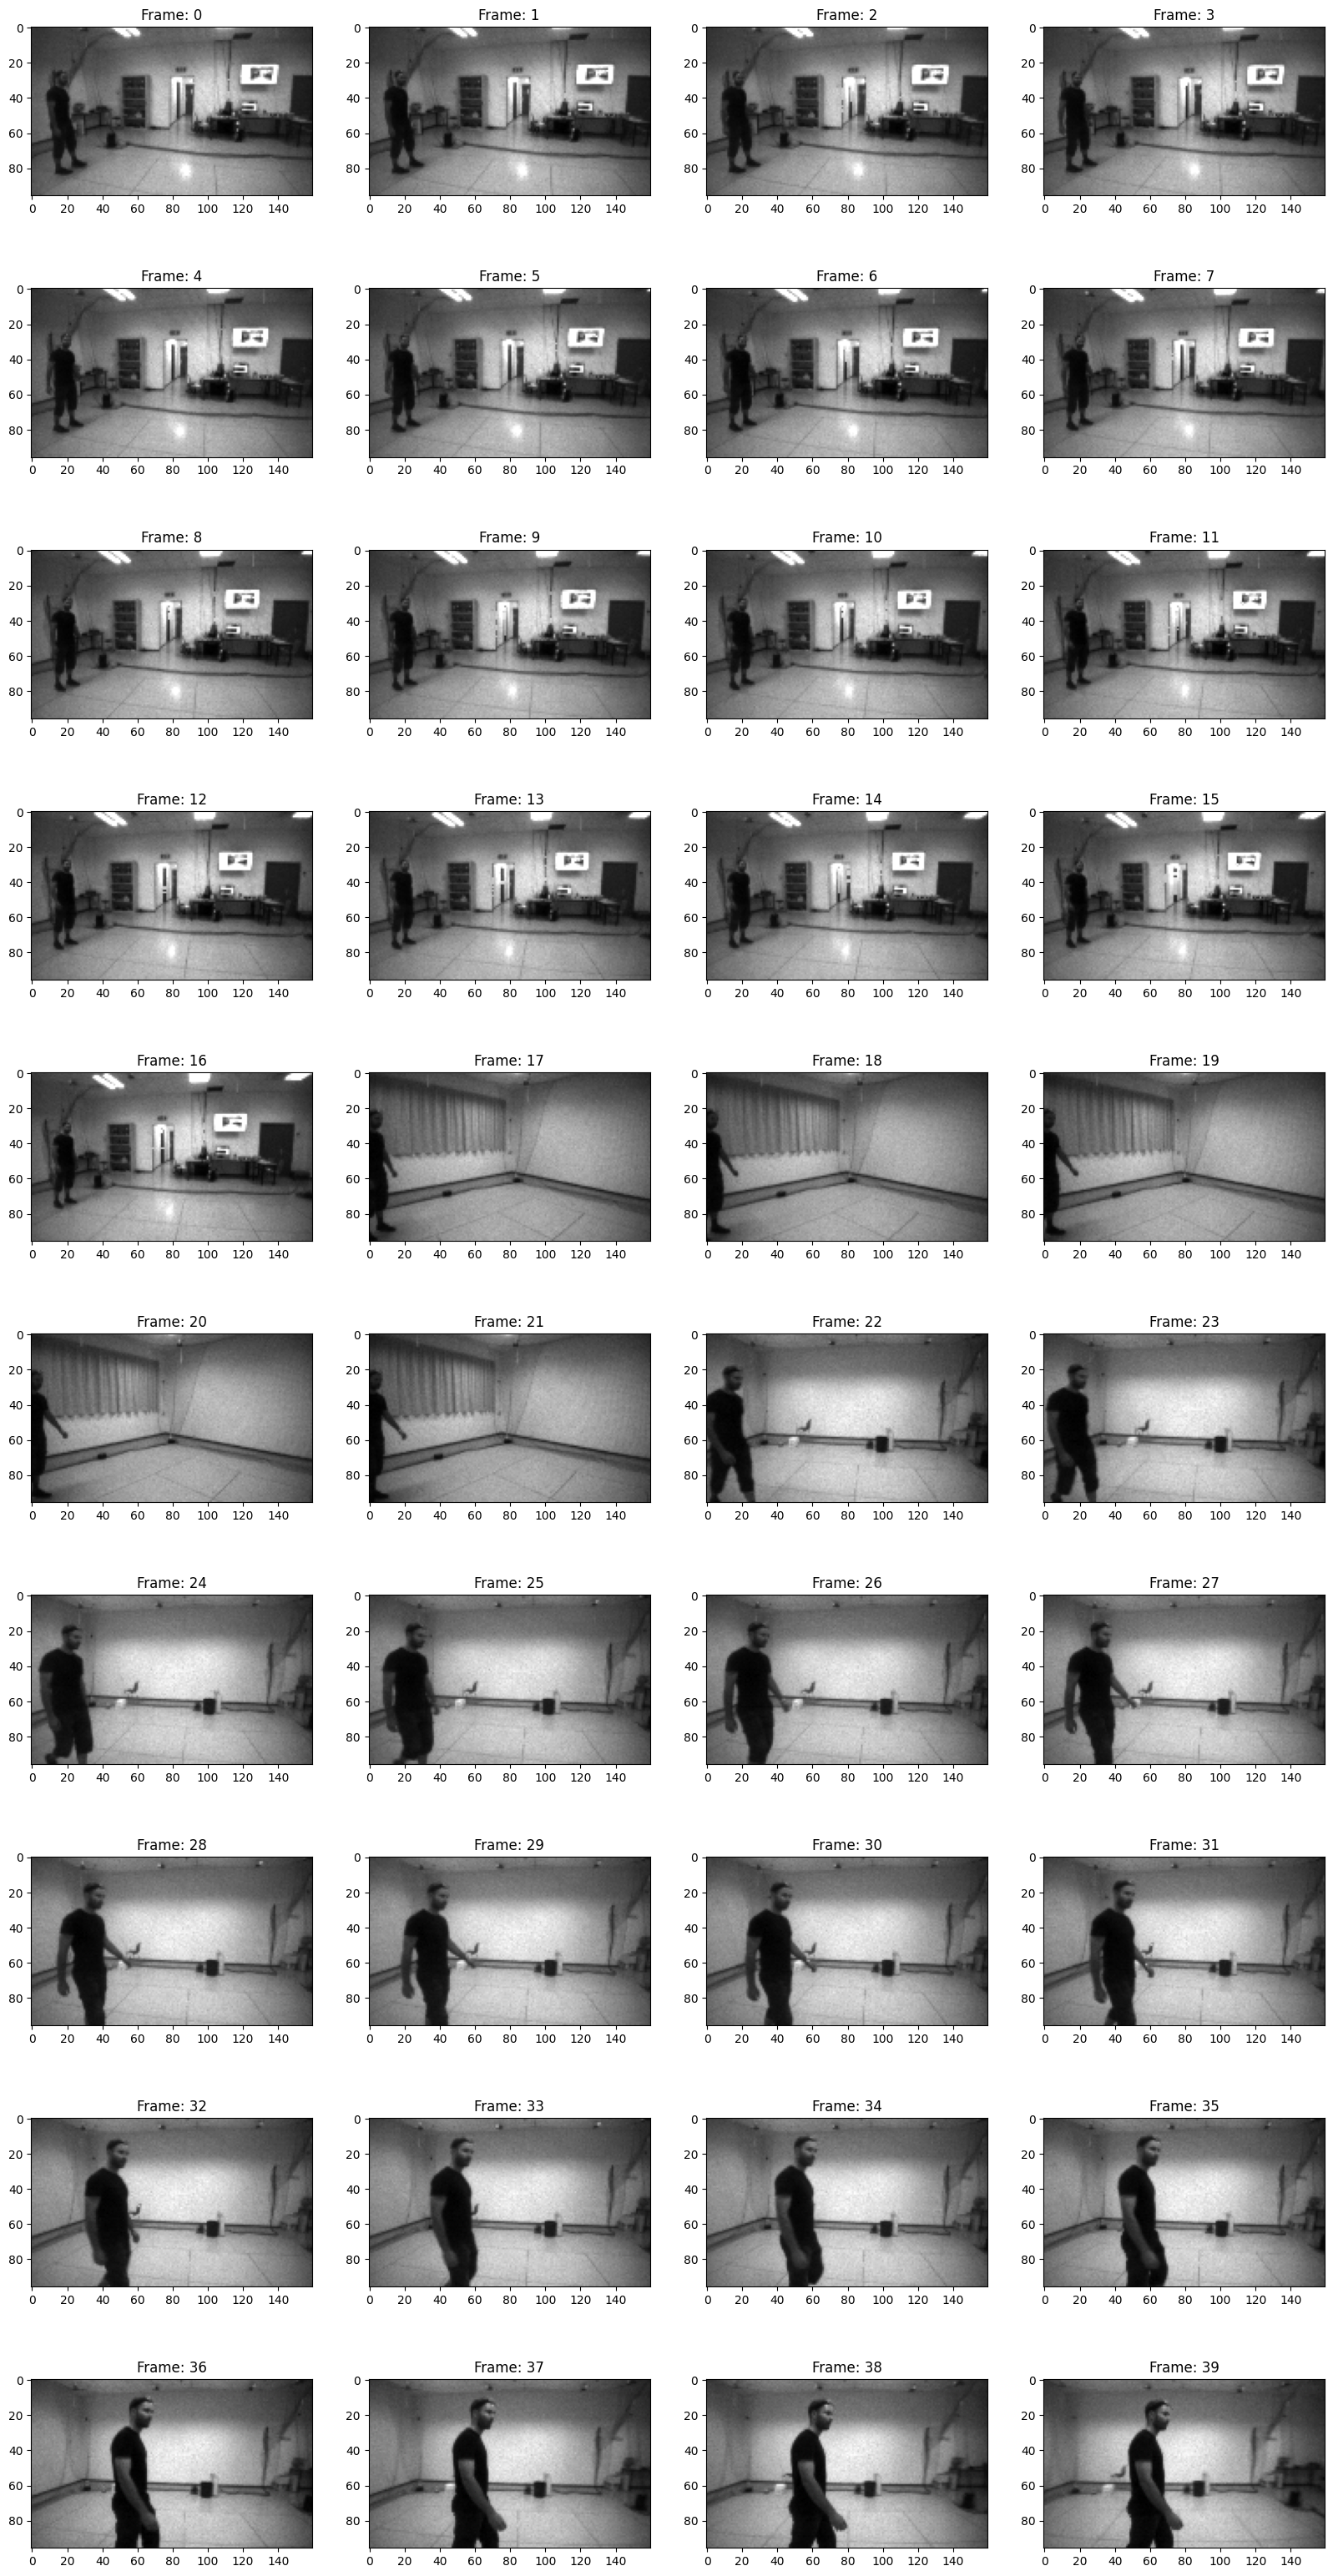

In [4]:
n_rows = 10
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 40))
for i, (x, y) in enumerate(test_set):
    axes[i // n_cols][i % n_cols].imshow(x[0], cmap="gray")
    axes[i // n_cols][i % n_cols].set_title(f"Frame: {i}")
    if i == n_cols * n_rows - 1:
        break
    

## Find optimal patches for each frame

In [5]:
model_path = "pulp_frontnet/PyTorch/Models/Frontnet160x32.pt"
model = FrontnetModel()
ModelManager.Read(model_path, model)
model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

Frontnet(
  (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ConvBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (layer2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

In [6]:
optimizer_factories: List[Callable[[], Optimizer]] = [
    lambda: RandomOptimizer(
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        model=model,
        n_dots_to_generate=1000,
        k_dots=1,
        dot_size=10,
    ),

    lambda: SlidingWindowOptimizer(
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        model=model,
        k_dots=1,
        dot_size=10,
        stride=5,
    ),

    lambda: SimulatedAnnealingOptimizer(
        x0=(80, 45),
        stride=10,
        max_iters=1000,
        model=model,
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        debug=False,
    ),

    lambda: GeneticOptimizer(
        n_iters=20,
        population_size=100,
        model=model,
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        max_x=160,
        max_y=96,
        dot_size=10,
        elitism=False,
        debug=False,
    ),
    
    lambda: GeneticOptimizer(
        n_iters=20,
        population_size=100,
        model=model,
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        max_x=160,
        max_y=96,
        dot_size=10,
        elitism=True,
        debug=False,
    ), 
]

In [14]:
optimizer_names = [
    "RandomOptimizer", "SlidingWindowOptimizer", "SimulatedAnnealingOptimizer", "GeneticOptimizer", "GeneticOptimizerElitism"
]
User = Query()

In [15]:
def get_dbs(suffix):
    dbs = [
        TinyDB(f"results_dbs/random_{suffix}.json"),
        TinyDB(f"results_dbs/sliding_{suffix}.json"),
        TinyDB(f"results_dbs/annealing_{suffix}.json"),
        TinyDB(f"results_dbs/genetic_{suffix}.json"),
        TinyDB(f"results_dbs/genetic_elitism_{suffix}.json"),
    ]
    return dbs

In [18]:
def plot_patch_results(db_suffix: str, n_rows: int, from_id: int = 1000):
    dbs = get_dbs(suffix=db_suffix)
    n_cols = len(dbs)
    to_id = from_id + n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 5 * n_rows))

    row_id = 0
    for i in tqdm(range(from_id, to_id), desc="Plotting patches", total=to_id - from_id):
        x, y = test_set[i]
        for j, optimizer_name in enumerate(optimizer_names):
            results = dbs[j].search(User.image_idx == i)[0]  
            best_cost: float = results[optimizer_name][0]
            best_patch: Tuple[int, int] = results[optimizer_name][1]
            
            img_copy = x.numpy().copy()[0]
            apply_path(
                img=img_copy,
                x=best_patch[0],
                y=best_patch[1],
                size=10,
            )
            axes[row_id][j].imshow(img_copy, cmap="gray")
            axes[row_id][j].set_title(f"{optimizer_name}\ncost {best_cost:.2f}, patch: {best_patch}")
        row_id += 1

In [20]:
def get_all_costs(db_suffix: str):
    all_costs = {
        name: [] for name in optimizer_names 
    }
    dbs = get_dbs(suffix=db_suffix)

    for i in tqdm(range(len(test_set)), desc=f"Checking results for {db_suffix}", total=len(test_set)):
        for j, optimizer_name in enumerate(optimizer_names):
            results = dbs[j].search(User.image_idx == i)[0]  
            best_cost: float = results[optimizer_name][0]
            best_patch: Tuple[int, int] = results[optimizer_name][1]
                
            all_costs[optimizer_name].append(best_cost)
    return all_costs

In [22]:
def plot_all_costs(all_costs):
    fig, axes = plt.subplots(2, 3, figsize=(25, 15))
    for i, optimizer_name in enumerate(optimizer_names):
        axes[i // 3][i % 3].hist(
            all_costs[optimizer_name], 
            bins=int(np.sqrt(len(test_set))),
        )
        mean_cost = np.mean(all_costs[optimizer_name])
        axes[i // 3][i % 3].axvline(mean_cost, c="red")
        axes[i // 3][i % 3].set_title(f"{optimizer_name} costs, mean = {mean_cost:.2f}")

## Untargeted attack on xyz

Plotting patches: 100%|██████████| 10/10 [00:00<00:00, 22.14it/s]


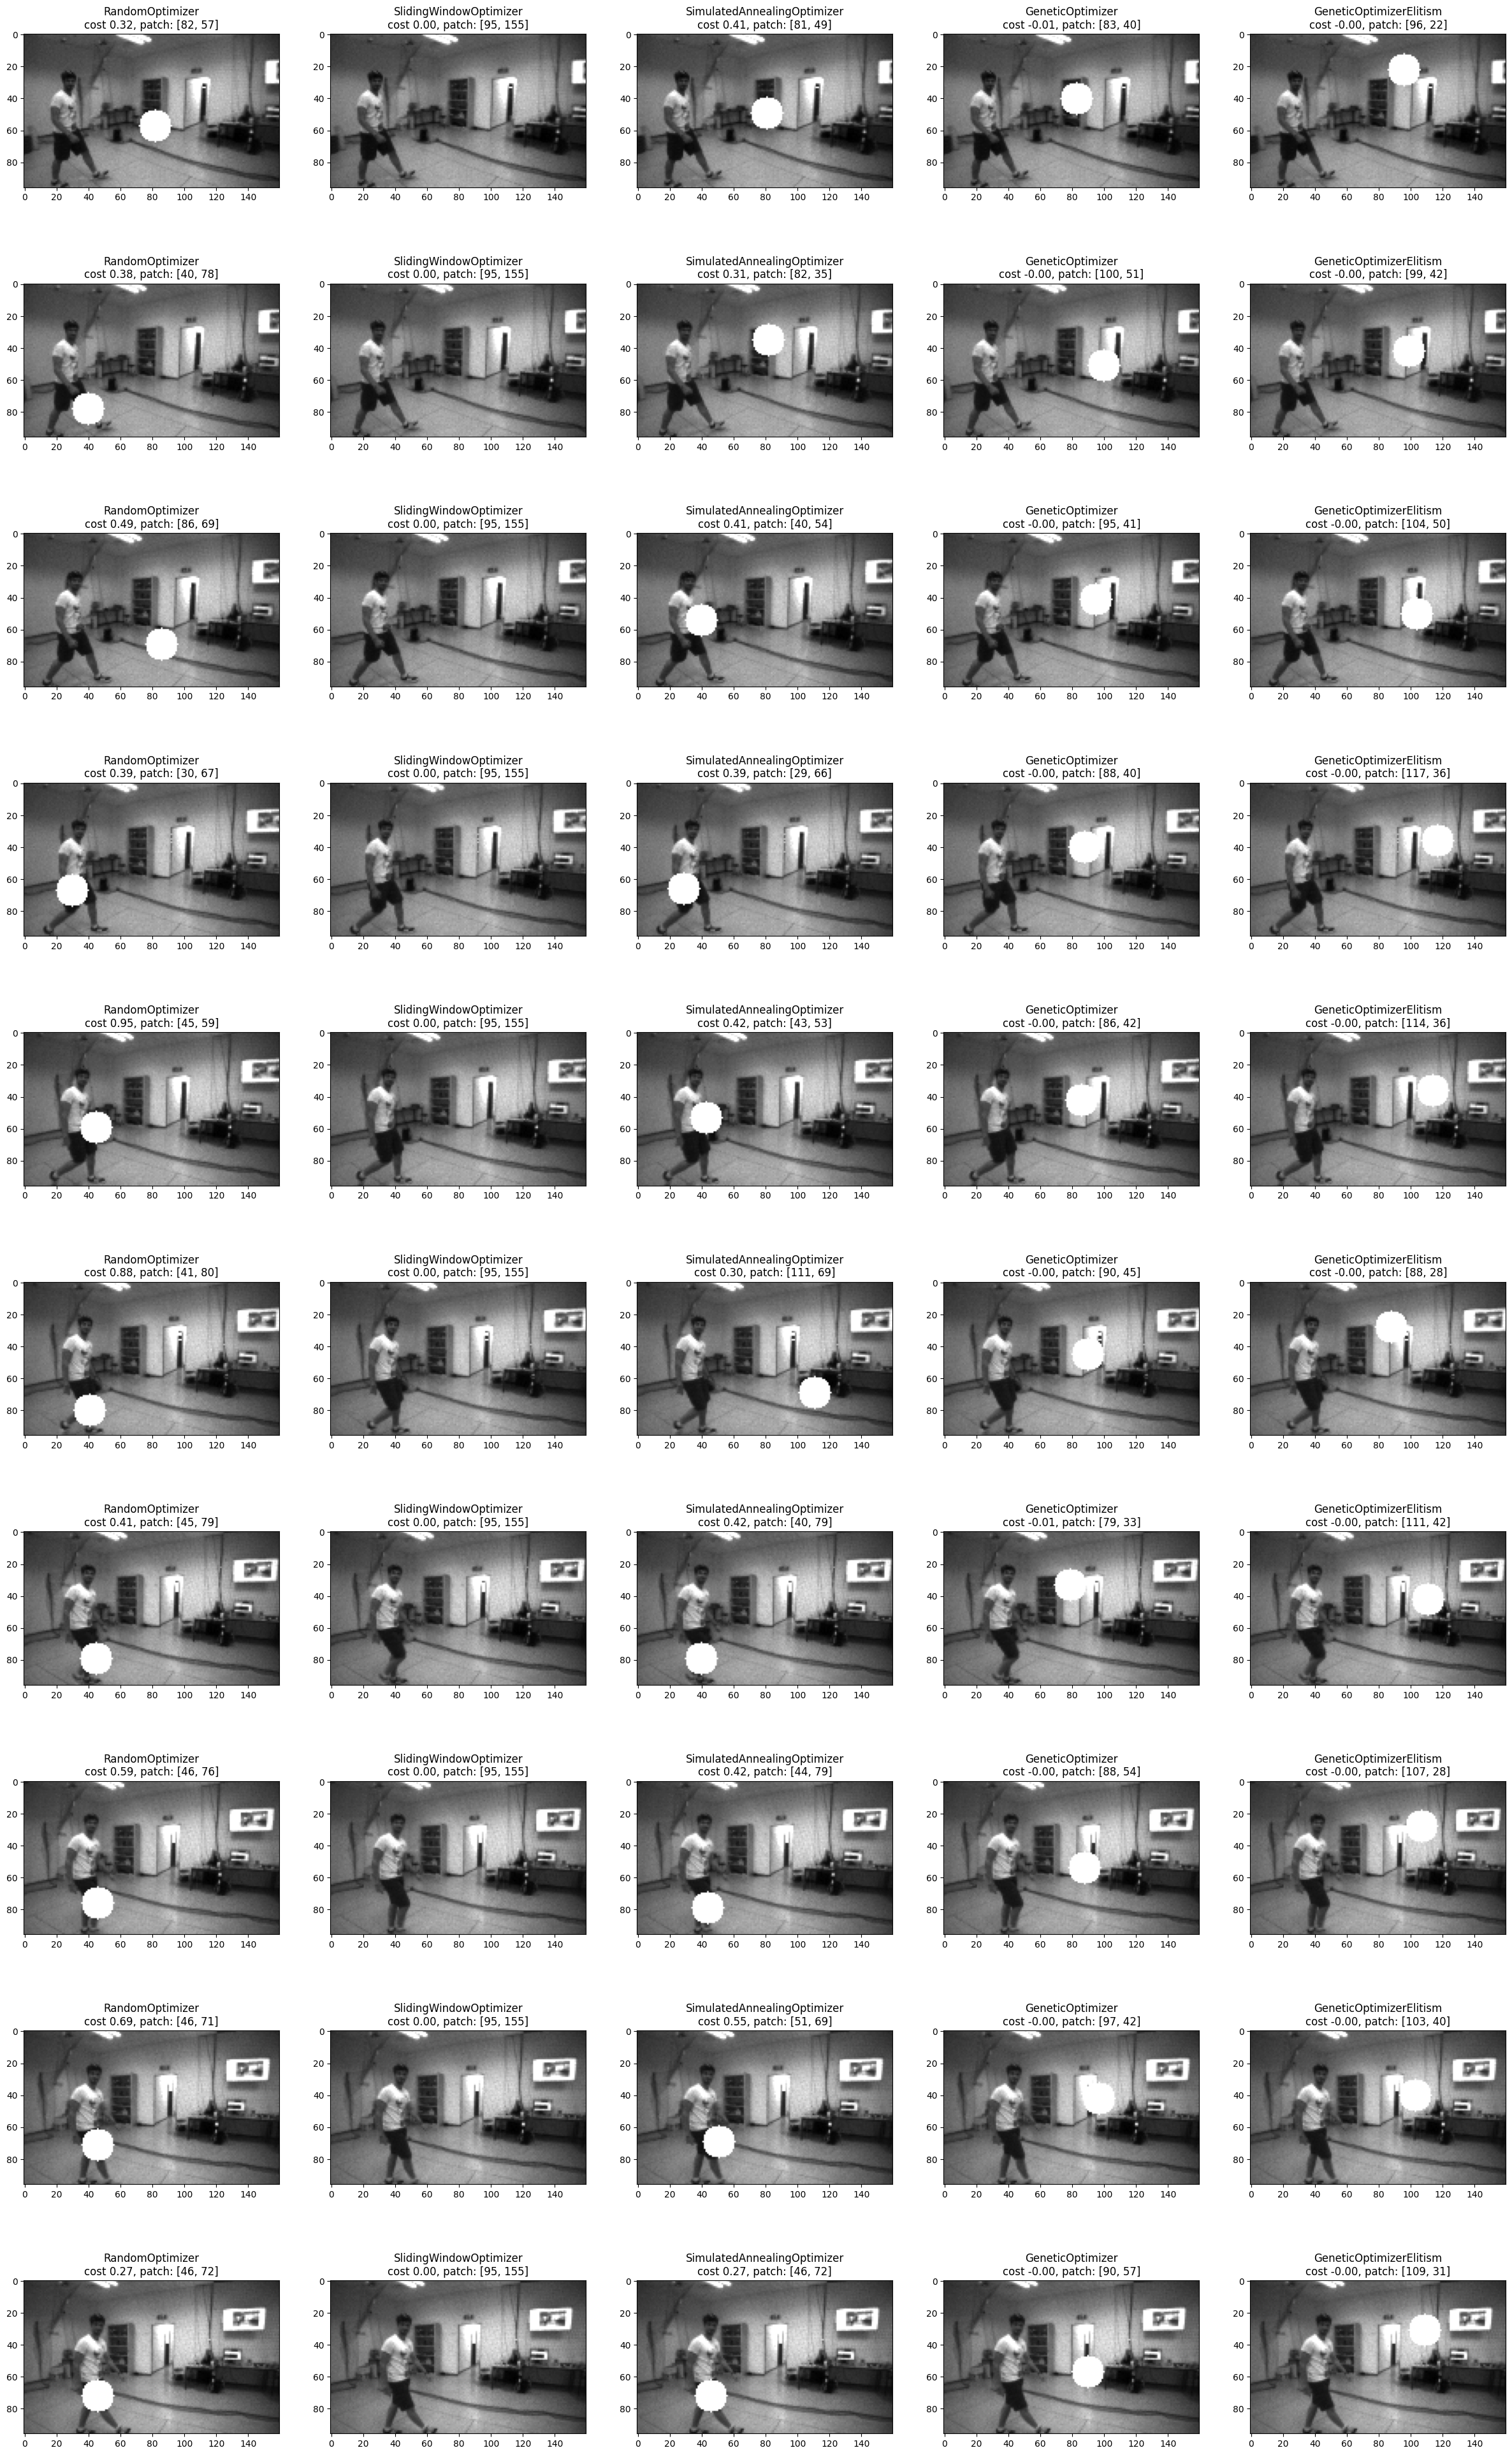

In [19]:
plot_patch_results(
    db_suffix="xyz",
    n_rows=10,
)

In [21]:
all_costs_xyz = get_all_costs(db_suffix="xyz")

Checking results for xyz: 100%|██████████| 4028/4028 [02:58<00:00, 22.57it/s]


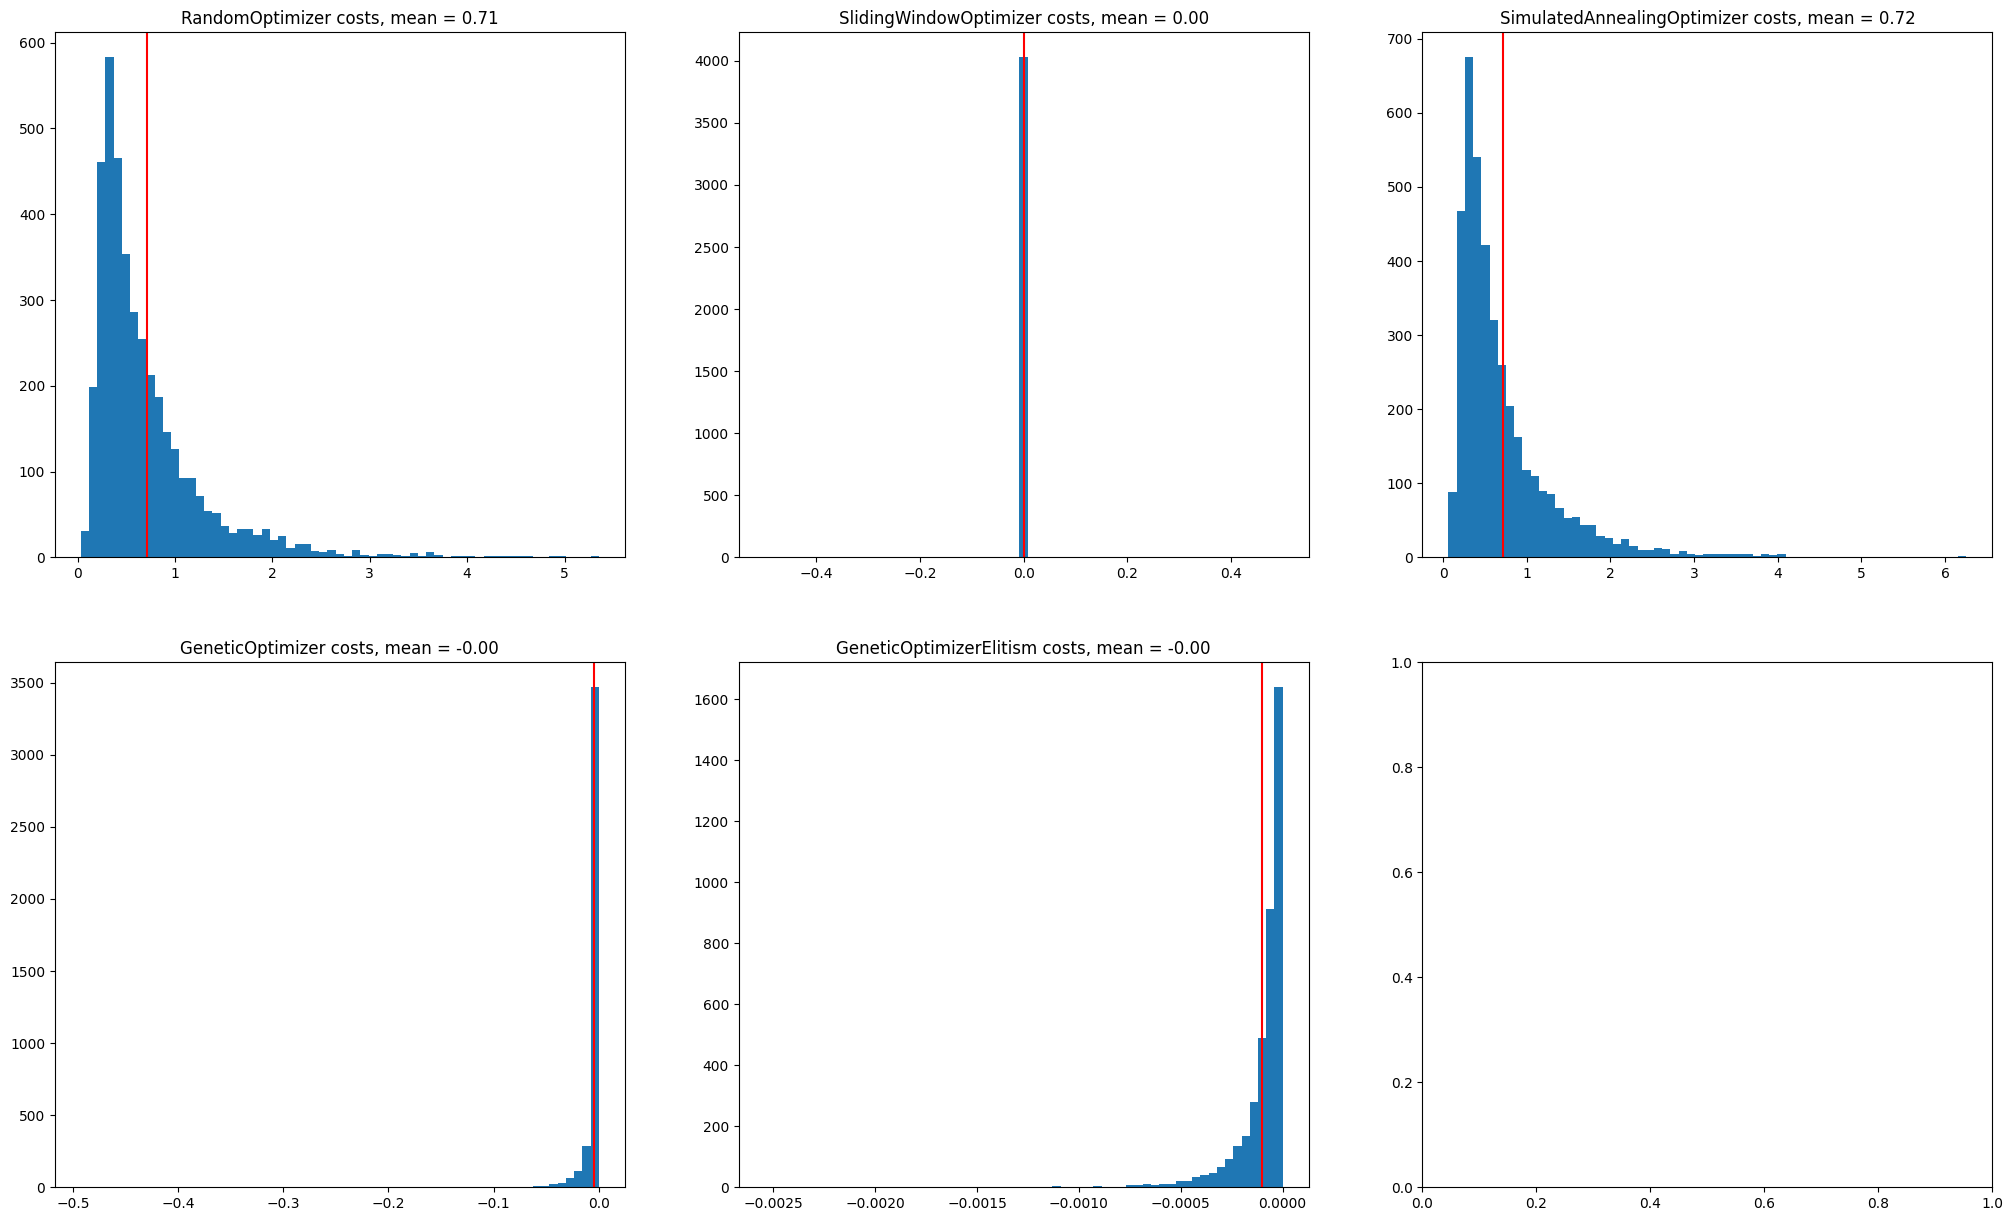

In [23]:
plot_all_costs(all_costs=all_costs_xyz)

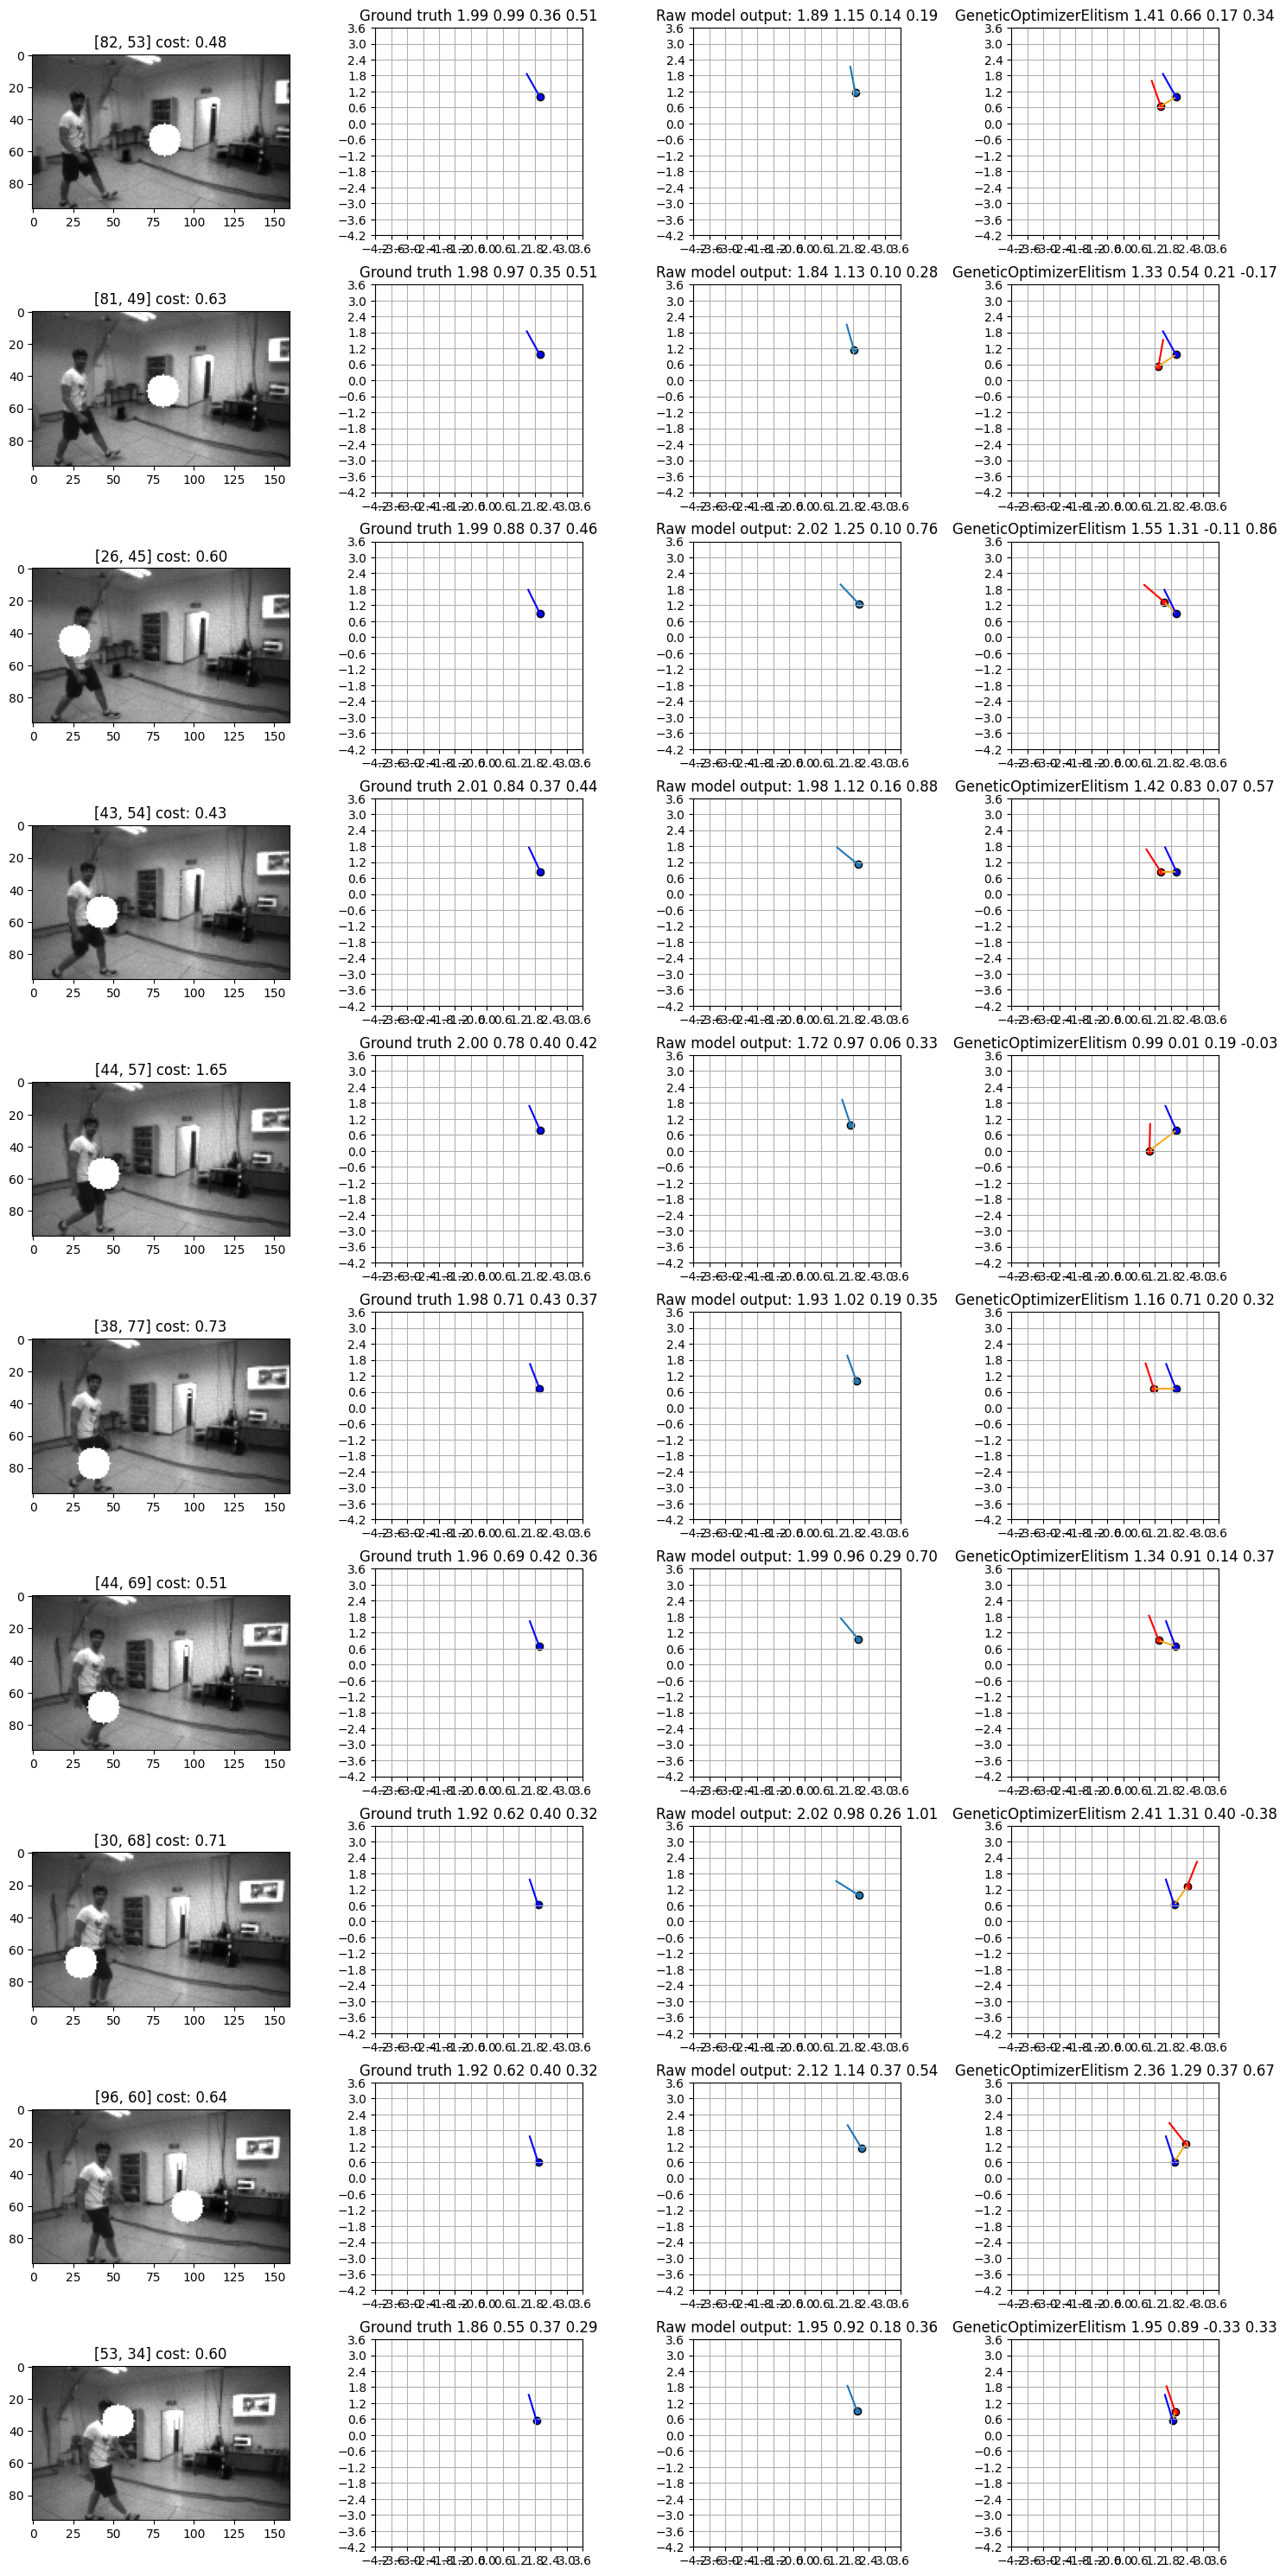

In [103]:
def rotate_point(angle: float, cx: float, cy: float, x: float, y: float):
    s = np.sin(angle)
    c = np.cos(angle)
    x -= cx
    y -= cy
    
    x_new = x * c - y * s
    y_new = x * s + y * c
    
    x = x_new + cx
    y = y_new + cy
    return x, y

nrows = 10
ncols = 4
from_id = 1000
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 30))
fig.tight_layout(pad=2)

for i in range(nrows):
    for j in range(1, ncols):
        min_range, max_range = -4.2, 3.6
        axes[i][j].set_xlim(min_range, max_range)
        axes[i][j].set_ylim(min_range, max_range)
        axes[i][j].set_xticks(np.arange(min_range, max_range, 0.6))
        axes[i][j].set_yticks(np.arange(min_range, max_range, 0.6))
        axes[i][j].set_aspect('equal')
        axes[i][j].grid()
    
    x, y, z, theta = test_set[i + from_id][1].numpy()
    og_x, og_y = x, y
    new_x, new_y = rotate_point(angle=theta, cx=x, cy=y, x=x, y=y + 1)
    og_new_x, og_new_y = new_x, new_y
    axes[i][1].scatter(x, y, edgecolors="black", color="blue")
    axes[i][1].plot((x, new_x), (y, new_y), color="blue")
    axes[i][1].set_title(f"Ground truth {x:.2f} {y:.2f} {z:.2f} {theta:.2f}")
    
    model_output = [x[0].detach().numpy() for x in model(test_set[i + from_id][0].unsqueeze(0))]
    x, y, z, theta = map(float, model_output)
    new_x, new_y = rotate_point(angle=theta, cx=x, cy=y, x=x, y=y + 1)
    axes[i][2].scatter(x, y, edgecolors="black")
    axes[i][2].plot((x, new_x), (y, new_y))
    axes[i][2].set_title(f"Raw model output: {x:.2f} {y:.2f} {z:.2f} {theta:.2f}")

    for j, optimizer_name in enumerate(optimizer_names):
        if optimizer_name == "GeneticOptimizerElitism":
            results = dbs[j].search(User.image_idx == i + from_id)[-1]
            
            img = test_set[i + from_id][0].squeeze().numpy().copy()
            apply_path(
                img=img,
                x=results[optimizer_name][1][0],
                y=results[optimizer_name][1][1],
                size=10,
            )
            axes[i][0].set_title(f"{results[optimizer_name][1]} cost: {results[optimizer_name][0]:.2f}")
            axes[i][0].imshow(
                img,
                cmap='gray'
            )

            model_output = [x[0].detach().numpy() for x in model(torch.Tensor(img).unsqueeze(0).unsqueeze(0))]
            x, y, z, theta = map(float, model_output)

            axes[i][3].scatter(og_x, og_y, edgecolors="black", color="blue")
            axes[i][3].plot((og_x, og_new_x), (og_y, og_new_y), color="blue")

            axes[i][3].set_title(f"{optimizer_name} {x:.2f} {y:.2f} {z:.2f} {theta:.2f}")
            attack_x, attack_y = rotate_point(angle=theta, cx=x, cy=y, x=x, y=y + 1)
            axes[i][3].scatter(x, y, edgecolors="black", color="red")
            axes[i][3].plot((x, attack_x), (y, attack_y), color="red")
       
            axes[i][3].arrow(og_x, og_y, x - og_x, y - og_y, width=0.01, color="orange", head_width=0.05)
            break
        